In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
#         self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    def extinction(self):
        '''
        Calculate the K band extinction and its uncertainty
        '''
        phot = obsphot[:,0]
        phot_err = obsphot[:,1]

        ### Reddening to K band extinctions based on Cardelli et al.
        ebpk_k = ((self.ccm_alav(leff['G_BPmag'])-self.ccm_alav(leff['Ksmag']))/self.ccm_alav(leff['Ksmag']))
        erpk_k = ((self.ccm_alav(leff['G_RPmag'])-self.ccm_alav(leff['Ksmag']))/self.ccm_alav(leff['Ksmag']))
        ejk_k = ((self.ccm_alav(leff['Jmag'])-self.ccm_alav(leff['Ksmag']))/self.ccm_alav(leff['Ksmag']))
        ehk_k = ((self.ccm_alav(leff['Hmag'])-self.ccm_alav(leff['Ksmag']))/self.ccm_alav(leff['Ksmag']))

        e_k = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        ### Spline 
        # pick isochrone points with temperatures within 100 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]

        # sort teffs
        sidx = np.argsort(iso_['logTe'])
        slogTe = iso_['logTe'][sidx]
        _, uidx = np.unique(slogTe,return_index=True)
        slogTe = slogTe[uidx]

        calc_aks = 999999.0*np.ones(4)
        calc_aks_err = 999999.0*np.ones(4)

        coeff0s = 999999.0*np.ones(4)
        for i in range(4):
            try:
                coeff = np.polyfit(10**slogTe,(iso_[labels[i]]-iso_['Ksmag'])[sidx][uidx],1)
                color_line = np.poly1d(coeff)
                calc_aks[i] = np.divide((self.phot[i]-self.phot[-1])-color_line(self.teff),e_k[i])
                coeff0s[i] = coeff[0]

            except:
                calc_aks[i] = 999999.0 
                calc_aks_err[i] = 999999.0

        calc_aks_err = np.sqrt(np.divide(np.square(self.phot_err[:-1])+
                                         np.square(np.multiply(coeff0s,teff_err)),np.square(e_k)))

        ### Weighted Mean
        wgts = np.square(np.reciprocal(calc_aks_err))
        wgts_sum = np.sum(wgts)

        ak = np.sum(np.multiply(calc_aks,wgts))/wgts_sum
        ak_err = np.sqrt(np.reciprocal(wgts_sum))
        
        self.ak = ak
        self.ak_err = ak_err
        
        return ak, ak_err

#         return ak, ak_err
        
#     def teff_2_appmags(self,teff,age,ak,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,ak])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
    
#     def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
#             guess_aks: [array] initial guesses for Ak 
            
#         Output:
#         ------
#             best_params: [array] best fitting age and Ak 
#             best_params_err:
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_aks = []
#         curve_ages_err = []
#         curve_aks_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)):
#             for k in range(len(guess_aks)):  
#                 try:
#                     # calculate best fit parameters and covariance matrix
#                     popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
#                                           bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
#                                           absolute_sigma=True,maxfev=5000)

#                     # populate lists
#                     curve_ages.append(popt[0])
#                     curve_aks.append(popt[1])
#                     curve_ages_err.append(np.sqrt(pcov[0][0]))
#                     curve_aks_err.append(np.sqrt(pcov[1][1]))
#                     curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
#                     curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

#                 except:
#                     #populate lists
#                     curve_mags = 999999.0*np.ones(5)
#                     curve_ages.append(999999.0)
#                     curve_aks.append(999999.0)
#                     curve_ages_err.append(999999.0)
#                     curve_aks_err.append(999999.0)
#                     curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         ak = np.asarray(curve_aks)[idx]
#         age_err = np.asarray(curve_ages_err)[idx]
#         ak_err = np.asarray(curve_aks_err)[idx]

#         best_params = np.array([age,ak])
#         best_params_err = np.array([age_err,ak_err])
#         best_mags = self.teff2appmags(self.teff,age,ak)

#         if verbose:
#             print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
#             print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
#             print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_params, best_params_err
        
#     def get_ak(self,age,verbose=False):
#         '''
#         Calculate the K band (fiducial band here) extintion by interpolating color index as a function
#         of temperature for a given age.

#         Inputs:
#         ------
#         age: [float] age in Gyr

#         Output:
#         ------
#         ak: extinction in the K band
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         akdist = 999999.0*np.ones(nsamples)

#         ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))
#         ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))

#         ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

#         lgage = np.log10(age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]

#                 ### use a spline to get the intrinsic color and calculate the reddening
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))

#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print(ccm)
#                     print(np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)
#                 akdist[j] = calc_ak

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out single isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)   
#                     akdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
#                     color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
#                     age_spl_interp = np.poly1d(np.squeeze(
#                         np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
#                     if verbose:
#                         print('interp',age_spl_interp)
#                         print('logteff',lgteffdist[j])
#                         print('interp age',age_spl_interp(lgteffdist[j]))
#                         print('color',self.phot[i]-self.phot[4])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))
#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print('CCM: ',ccm)
#                     print('Ak each band',np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)

# #                 print(calc_ak)
#                 akdist[j] = calc_ak
            
# #         print(akdist)
#         med_calc_ak = np.nanmedian(akdist)
#         mad_calc_ak = self.mad(akdist)
        
#         if np.isfinite(med_calc_ak)==False:
#             med_calc_ak = 999999.0
#         if np.isfinite(mad_calc_ak)==False:
#             mad_calc_ak = 999999.0
        
#         self.ak = med_calc_ak
#         self.ak_err = mad_calc_ak
        
#         return np.array([med_calc_ak,mad_calc_ak])

#     def teff_2_appmags_age(self,teff,age,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak_calib
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,self.ak_calib])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
        
#     def get_age(self,guess_ages=np.arange(0,17),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
#             guess_aks: [array] initial guesses for Ak 
            
#         Output:
#         ------
#             best_params: [array] best fitting age and Ak 
#             best_params_err:
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_ages_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)): 
#             try:
#                 # calculate best fit parameters and covariance matrix
#                 popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
#                                       bounds=(0.,17.),method='trf',sigma=self.phot_err,
#                                       absolute_sigma=True,maxfev=5000)

#                 # populate lists
#                 curve_ages.append(popt[0])
#                 curve_ages_err.append(np.sqrt(pcov[0][0]))
#                 curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
#                 curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

#             except:
#                 #populate lists
#                 curve_ages.append(999999.0)
#                 curve_ages_err.append(999999.0)
#                 curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         self.age = age
#         age_err = np.asarray(curve_ages_err)[idx]

#         best_params = np.array([age,age_err])
# #         best_params_err = np.array([age_err,ak_err])
#         best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

#         if verbose:
#             print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
#             print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_params
    
#     def get_mass(self,verbose=False):
#         '''
#         Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

#         Output:
#         ------
#         mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         massdist = 999999.0*np.ones(nsamples)

#         if self.age == 999999.0:
#             return np.array([999999.0,999999.0])
        
#         lgage = np.log10(self.age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]
                
#                 ### Use spline to find mass for a point in lgteffdist
#                 mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
#                 massdist[j] = mass_spl(np.log10(lgteffdist[j]))

#                 if verbose:
#                     print('mass',mass_spl(np.log10(lgteffdist[j])))

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out single isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)   
#                     massdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9

#                 mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
#                 mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(
#                     np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

#                 massdist[j] = age_spl_interp(self.age)
            
#         med_calc_mass = np.nanmedian(massdist)
#         mad_calc_mass = self.mad(massdist)
        
#         if np.isfinite(med_calc_mass)==False:
#             med_calc_mass = 999999.0
#         if np.isfinite(mad_calc_mass)==False:
#             mad_calc_mass = 999999.0
        
#         self.mass = med_calc_mass
#         self.mass_err = mad_calc_mass
        
#         mass_arr = np.array([med_calc_mass,mad_calc_mass])
#         return mass_arr
    
# #     def test(self,x=3.0):
# #         print('Hello World!')
    
#     def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age
        
#         Inputs:
#         ------
#             best_fit_age: best fit age in Gyr
#             star_name: name of star
#             lit_age: known literature age in Gyr
#             filename: name of file if saving plot
#         '''
        
#         # intialize arrays
#         ages = np.arange(0,15,0.25)
#         theos_w_ext = 999999.0*np.ones((len(ages),5))
#         theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
#         # Calculate theoretical mags given an age in ages
#         for i in range(len(ages)):
#             theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
#             theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for j in range(5):
#             # with extinction
#             ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
#             ax[j].plot(theos_w_ext[:,j],ages)
            
#             # without extinction
#             ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
#             ax[j].plot(theos_wo_ext[:,j],ages)
            
#             ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age != None:
#                 ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
#             ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
#             ax[j].set_xlim(-14,14)
#             ax[j].set_ylim(bottom=0.01)
            
#             ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
#             ax[j].set_xlabel(r'Magnitude')
        
#         ax[0].legend()
        
#         ax[0].set_ylabel('Age')
        
#         if star_name != None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
#                                                                           self.ak,self.distance))
            
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
#                                                                       self.distance))
            
#         if filename != None:
#             plt.savefig(filename,bbox_inches='tight')
            
#         plt.show()
        
#     def mass_2_age(self,mass):
#         '''

#         Input:
#         -----
#             mass: mass of star

#         Output:
#         ------
#             age: age of star
#         '''

#         try:
#             mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

#             iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
#             iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

#             # younger
#             sidx_lo = np.argsort(iso_lo['MH'])
#             sMH_lo = iso_lo['MH'][sidx_lo]
#             _, uidx_lo = np.unique(sMH_lo,return_index=True)
#             sMH_lo = sMH_lo[uidx_lo]

#             spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

#             # older
#             sidx_hi = np.argsort(iso_hi['MH'])
#             sMH_hi = iso_hi['MH'][sidx_hi]
#             _, uidx_hi = np.unique(sMH_hi,return_index=True)
#             sMH_hi = sMH_hi[uidx_hi]

#             spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

#             # final spline
#             final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
#             age = final_spl(mass)
#             return age
#         except:
#             return 999999.0
        
#     def mass_2_age_MESA(self,mass,mesa):
#         '''

#         Input:
#         -----
#             mass: mass of star

#         Output:
#         ------
#             age: age of star
#         '''

#         try:
#             mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

#             iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
#             iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

#             # younger
#             sidx_lo = np.argsort(iso_lo['MH'])
#             sMH_lo = iso_lo['MH'][sidx_lo]
#             _, uidx_lo = np.unique(sMH_lo,return_index=True)
#             sMH_lo = sMH_lo[uidx_lo]

#             spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

#             # older
#             sidx_hi = np.argsort(iso_hi['MH'])
#             sMH_hi = iso_hi['MH'][sidx_hi]
#             _, uidx_hi = np.unique(sMH_hi,return_index=True)
#             sMH_hi = sMH_hi[uidx_hi]

#             spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

#             # final spline
#             final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
#             age = final_spl(mass)
#             return age
#         except:
#             return 999999.0
        
#     def mass_2_age_MESA(self,star_mass,mesa):
#         '''

#         Input:
#         -----
#             star_mass: star_mass of star

#         Output:
#         ------
#             age: age of star
#         '''

#         try:
#             star_mass_lo,star_mass_hi = neighbors(mesa['star_mass'],star_mass)

#             iso_lo = mesa[np.where(mesa['star_mass']==star_mass_lo)]
#             iso_hi = mesa[np.where(mesa['star_mass']==star_mass_hi)]

#             # younger
#             sidx_lo = np.argsort(iso_lo['MH'])
#             sMH_lo = iso_lo['MH'][sidx_lo]
#             _, uidx_lo = np.unique(sMH_lo,return_index=True)
#             sMH_lo = sMH_lo[uidx_lo]

#             spl_lo = interp1d(sMH_lo,10**iso_lo['log10_isochrone_age_yr'][sidx_lo][uidx_lo]/10**9)

#             # older
#             sidx_hi = np.argsort(iso_hi['MH'])
#             sMH_hi = iso_hi['MH'][sidx_hi]
#             _, uidx_hi = np.unique(sMH_hi,return_index=True)
#             sMH_hi = sMH_hi[uidx_hi]

#             spl_hi = interp1d(sMH_hi,10**iso_hi['log10_isochrone_age_yr'][sidx_hi][uidx_hi]/10**9)

#             # final spline
#             final_spl = interp1d([star_mass_lo,star_mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
#             age = final_spl(star_mass)
#             return age
#         except:
#             return 999999.0

In [119]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

ak_ebpk = ccm_alav(leff['K'],3.1)/(ccm_alav(leff['BP'],3.1)-ccm_alav(leff['K'],3.1))
ak_erpk = ccm_alav(leff['K'],3.1)/(ccm_alav(leff['RP'],3.1)-ccm_alav(leff['K'],3.1))
ak_ejk = ccm_alav(leff['K'],3.1)/(ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))
ak_ehk = ccm_alav(leff['K'],3.1)/(ccm_alav(leff['H'],3.1)-ccm_alav(leff['K'],3.1))
# ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

def salaris(feh,afe):
    '''
    Calculate the Salaris corrected [Fe/H] of a star

    Inputs:
    ------
        feh: [Fe/H] and error
        afe: alpha abundance and error

    Outputs:
    -------
        salfeh: Salaris corrected [Fe/H]
        salfeh_err: error in Salaris corrected [Fe/H]
    '''

    # asplund = np.array([8.69,8.06,7.55,7.51,7.12,6.30,4.97]) # Asplund et al. 2021
    # asplund_err = np.array([0.04,0.05,0.03,0.03,0.03,0.03,0.05]) # Asplund et al. 2021
    # ZX_sol = 0.0187 # (Z/X) Asplund et al. 2021
    # massH = 1.008 # IUPAC
    # atmmass = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867]) # IUPAC
    # mass_ratio = atmmass/massH    
    # XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    # sal_a = np.sum(XZ_k) = 0.6594921942359003
    # sal_b = 1 - sal_a = 0.34050780576409967

    sal_a = 0.6594921942359003
    sal_b = 0.34050780576409967

    salfeh = feh+np.log10(sal_a*(10**(afe))+sal_b)
#     salfeh_err = np.sqrt(feh[1]**2+((1-sal_b/(sal_a*(10**(afe[0]))+sal_b))*afe[1])**2)

    return salfeh #, salfeh_err

In [3]:
# PARSEC
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','int_IMF','Mini','logAge','logTe','logg','Xc','Xn','Xo','Gmag','G_BPmag',
                  'G_RPmag','Jmag','Hmag','Ksmag','mbolmag']

<ipython-input-6-44cbceeca345>:31: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


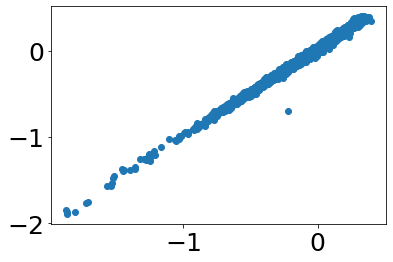

In [6]:
# APOKASC 
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

_, _, k3idx2 = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

salfeh = salaris(kdr17['FE_H'],apoafe)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [8]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

# ### Plot
# plt.figure(figsize=[10,10])
# plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
# plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
# plt.legend()
# plt.ylim(bottom=-3.0)
# plt.xlabel('Magnitude')
# plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [7]:
kdr17.columns

ColDefs(
    name = 'FILE'; format = '64A'
    name = 'APOGEE_ID'; format = '30A'
    name = 'TARGET_ID'; format = '58A'
    name = 'APSTAR_ID'; format = '71A'
    name = 'ASPCAP_ID'; format = '69A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SRC_H'; format = '16A'
    name = 'WASH_M'; format = 'E'
    name = 'WASH_M_ERR'; format = 'E'
    name = 'WASH_T2'; format = 'E'
    name = 'WASH_T2_ERR'; format = 'E'
    name = 'DDO51'; format = 'E'
    name = 'DDO51_ERR'; format = 'E'
    name = 'IRAC_3_6'; format = 'E'
    name = 'IRAC_3_6_ERR'; format = 'E'
    name = 'IRA

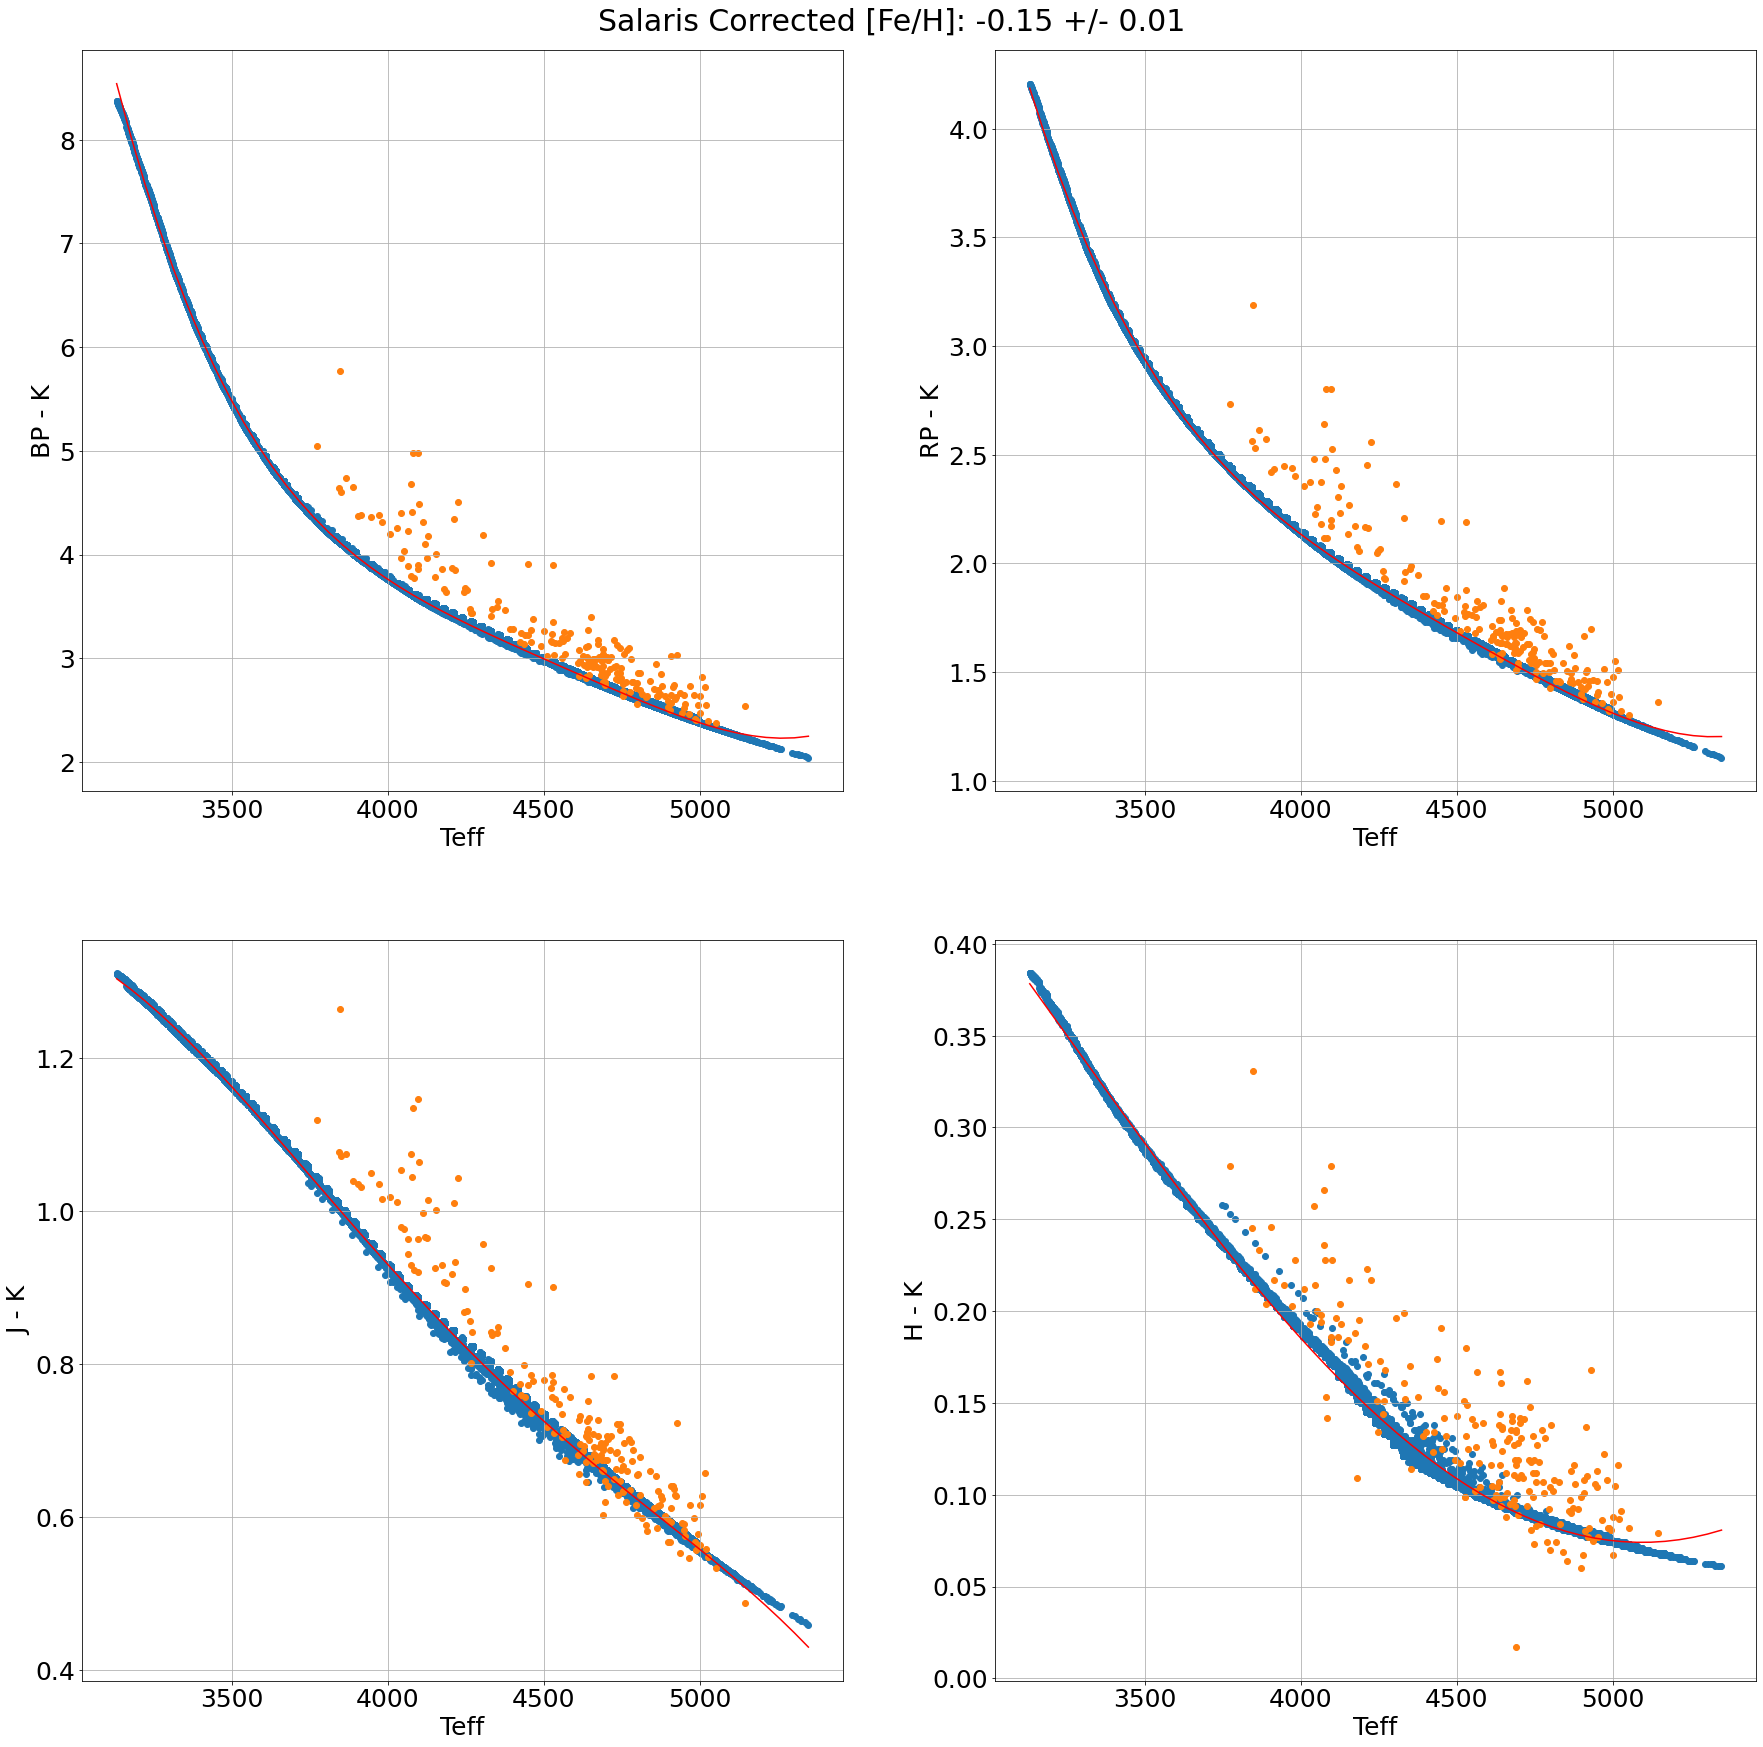

In [19]:
singfehpar = np.where(massive['MH']==closest(massive['MH'],-0.15))
singfehapo = np.where((salfeh>-0.15-0.01)&(salfeh<-0.15+0.01))

teffxs = np.linspace(10**min(massive['logTe'][singfehpar]),10**max(massive['logTe'][singfehpar]))

plt.figure(figsize=[30,30])

plt.subplot(221)

bpkspl = np.poly1d(np.polyfit(10**massive['logTe'][singfehpar],(massive['G_BPmag']-massive['Ksmag'])[singfehpar],4))

plt.scatter(10**massive['logTe'][singfehpar],(massive['G_BPmag']-massive['Ksmag'])[singfehpar])
plt.plot(teffxs,bpkspl(teffxs),c='r')
plt.scatter(kdr17['TEFF'][singfehapo],(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']-kdr17['K'])[singfehapo])
plt.xlabel(r'Teff')
plt.ylabel(r'BP - K')
plt.grid()

plt.subplot(222)

rpkspl = np.poly1d(np.polyfit(10**massive['logTe'][singfehpar],(massive['G_RPmag']-massive['Ksmag'])[singfehpar],4))

plt.scatter(10**massive['logTe'][singfehpar],(massive['G_RPmag']-massive['Ksmag'])[singfehpar])
plt.plot(teffxs,rpkspl(teffxs),c='r')
plt.scatter(kdr17['TEFF'][singfehapo],(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']-kdr17['K'])[singfehapo])
plt.xlabel(r'Teff')
plt.ylabel(r'RP - K')
plt.grid()

plt.subplot(223)

jkspl = np.poly1d(np.polyfit(10**massive['logTe'][singfehpar],(massive['Jmag']-massive['Ksmag'])[singfehpar],4))

plt.scatter(10**massive['logTe'][singfehpar],(massive['Jmag']-massive['Ksmag'])[singfehpar])
plt.plot(teffxs,jkspl(teffxs),c='r')
plt.scatter(kdr17['TEFF'][singfehapo],(kdr17['J']-kdr17['K'])[singfehapo])
plt.xlabel(r'Teff')
plt.ylabel(r'J - K')
plt.grid()

plt.subplot(224)

hkspl = np.poly1d(np.polyfit(10**massive['logTe'][singfehpar],(massive['Hmag']-massive['Ksmag'])[singfehpar],4))

plt.scatter(10**massive['logTe'][singfehpar],(massive['Hmag']-massive['Ksmag'])[singfehpar])
plt.plot(teffxs,hkspl(teffxs),c='r')
plt.scatter(kdr17['TEFF'][singfehapo],(kdr17['H']-kdr17['K'])[singfehapo])
plt.xlabel(r'Teff')
plt.ylabel(r'H - K')
plt.grid()

plt.suptitle(r'Salaris Corrected [Fe/H]: -0.15 +/- 0.01',y=0.9)
plt.show()

h-k do age cut

XXXXX fit around teff value low order

XXXXX wgt mean

0.49077544749130725


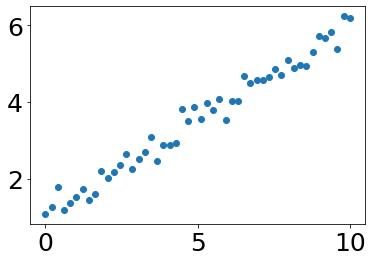

In [226]:
x = np.linspace(0,10)
y = 0.5*x+1.0 + np.random.normal(0.0,0.25,len(x))

coeff = np.polyfit(x,y,1)
spl = np.poly1d(coeff)
print(coeff[0])

plt.scatter(x,y)

In [222]:
spl

0.5123360062169723

In [305]:
10**massive['logAge']<5.

array([False, False, False, ..., False, False, False])

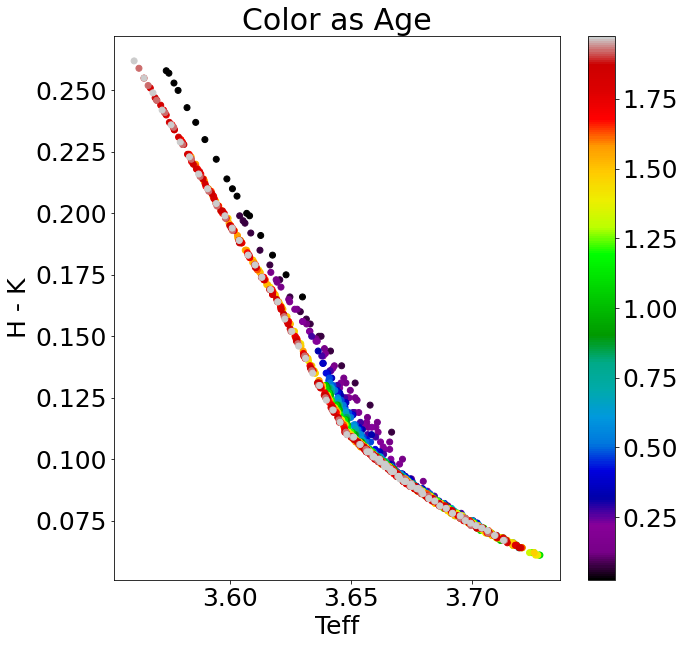

In [313]:
testage = np.where((massive['MH']==closest(massive['MH'],-0.15))&(10**massive['logAge']/10**9<2.))

plt.figure(figsize=[10,10])
plt.scatter(massive['logTe'][testage],(massive['Hmag']-massive['Ksmag'])[testage],
            c=10**massive['logAge'][testage]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'H - K')
plt.show()

In [314]:
def extinction(obsteff,salfeh,obsphot,isochrones):
    '''
    Calculate the K band extinction and its uncertainty
    
    Inputs:
    ------
        obsteff: Teff and Teff error of a star
        salfeh: salaris corrected [Fe/H]
        obsphot: observed photometry and errors 
    
    Output:
    ------
        ak: K and extinction
        ak_err: error in K band extinction
    '''
    
    teff = obsteff[0]
    teff_err = obsteff[1]
    
    phot = obsphot[:,0]
    phot_err = obsphot[:,1]
    
    ### Reddening to K band extinctions based on Cardelli et al.
    ebpk_k = ((ccm_alav(leff['BP'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1))
    erpk_k = ((ccm_alav(leff['RP'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1))
    ejk_k = ((ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1))
    ehk_k = ((ccm_alav(leff['H'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1))

    e_k = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])
    
    labels = np.array(['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag'])

    ### Spline 
    # pick isochrone points with temperatures with in 100 K
    singfeh = np.where(isochrones['MH']==closest(isochrones['MH'],salfeh))
    
    teffcut = np.where((isochrones['logTe'][singfeh]<np.log10(teff+100.))&
                       (isochrones['logTe'][singfeh]>np.log10(teff-100.)))
    iso_ = isochrones[singfeh][teffcut] 
    
    # sort teffs
    sidx = np.argsort(iso_['logTe'])
    slogTe = iso_['logTe'][sidx]
    _, uidx = np.unique(slogTe,return_index=True)
    slogTe = slogTe[uidx]

    calc_aks = 999999.0*np.ones(4)
    calc_aks_err = 999999.0*np.ones(4)
    
    coeff0s = 999999.0*np.ones(4)
    for i in range(4):
        try:
            coeff = np.polyfit(10**slogTe,(iso_[labels[i]]-iso_['Ksmag'])[sidx][uidx],1)
            color_line = np.poly1d(coeff)
            calc_aks[i] = np.divide((phot[i]-phot[-1])-color_line(teff),e_k[i])
            coeff0s[i] = coeff[0]

        except:
            calc_aks[i] = 999999.0 
            calc_aks_err[i] = 999999.0
            
    calc_aks_err = np.sqrt(np.divide(np.square(phot_err[:-1])+
                                     np.square(np.multiply(coeff0s,teff_err)),np.square(e_k)))
    
    ### Weighted Mean
    wgts = np.square(np.reciprocal(calc_aks_err))
    wgts_sum = np.sum(wgts)
    
    ak = np.sum(np.multiply(calc_aks,wgts))/wgts_sum
    
    ak_err = np.sqrt(np.reciprocal(wgts_sum))
    
    return ak, ak_err

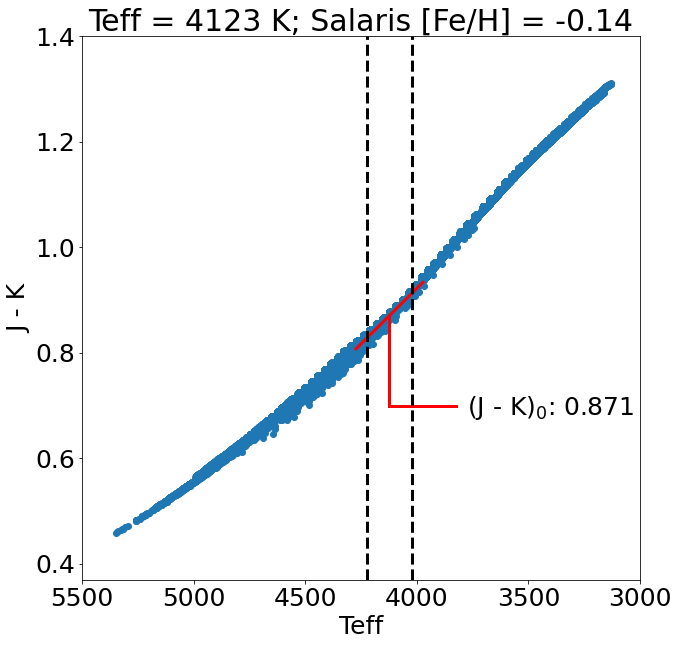

In [387]:
f_014 = np.where(massive['MH']==-0.14)

t = 4123.
smaller = np.where((massive['logTe'][f_014]<np.log10(t+100.))&(massive['logTe'][f_014]>np.log10(t-100.)))

plt.figure(figsize=[10,10])

plt.title(r'Teff = 4123 K; Salaris [Fe/H] = -0.14')

# plt.subplot(121)
plt.scatter(10**massive[f_014]['logTe'],(massive['Jmag']-massive['Ksmag'])[f_014])

p = np.poly1d(np.polyfit(10**massive[f_014]['logTe'][smaller],
                         (massive['Jmag']-massive['Ksmag'])[f_014][smaller],1))
plt.plot([t-150,t+150],[p(t-150),p(t+150)],c='r',lw=3.0,zorder=1)

plt.plot([t,t],[0.7,p(t)],lw=3.0,c='r')
plt.plot([t,3825],[0.7,0.7],lw=3.0,c='r')

plt.axvline(t-100.,c='k',ls='--',lw=3.0)
plt.axvline(t+100.,c='k',ls='--',lw=3.0)

plt.text(3775,0.6825,r'(J - K)$_0$: {:.3f}'.format(p(t)))

plt.xlim(3000,5500)
plt.ylim(0.37,1.4)
plt.gca().invert_xaxis()
plt.xlabel(r'Teff')
plt.ylabel(r'J - K')
plt.savefig('ext_schematic.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [315]:
ak_ext = 999999.0*np.ones(len(np.squeeze(ageevs)))
ak_ext_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_ak_calib = 999999.0*np.ones(len(np.squeeze(ageevs)))
# # kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))
# kasc_age_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
# # kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))
# # kasc_mass_err = 999999.0*np.ones(len(np.squeeze(ageevs)))

# apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
# apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

from tqdm import tqdm_notebook

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    
    te = te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = salaris(kdr17['FE_H'][i],apoafe[i])
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    
    ext = extinction(te,ab,op,massive)
    ak_ext[i] = ext[0]
    ak_ext_err[i] = ext[1]

<ipython-input-315-3a925a7a4ae8>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


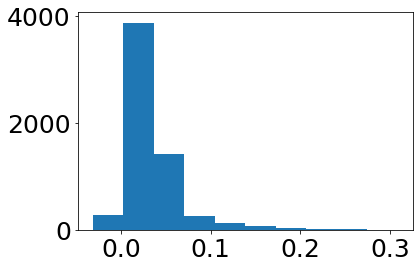

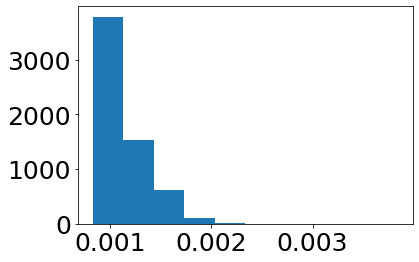

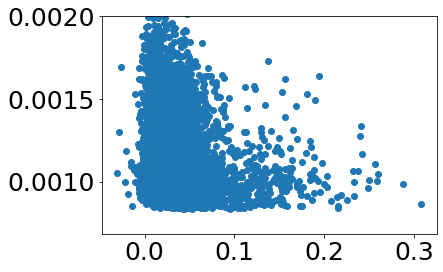

In [316]:
plt.hist(ak_ext)
np.nanmedian(ak_ext)
plt.show()

plt.hist(ak_ext_err)
np.nanmedian(ak_ext_err)
plt.show()

plt.scatter(ak_ext,ak_ext_err)
plt.ylim(top=0.002)
plt.show()

0.02366+/-0.01155
0.02866736893334211
-----
0.05380+/-0.00934
0.054958336


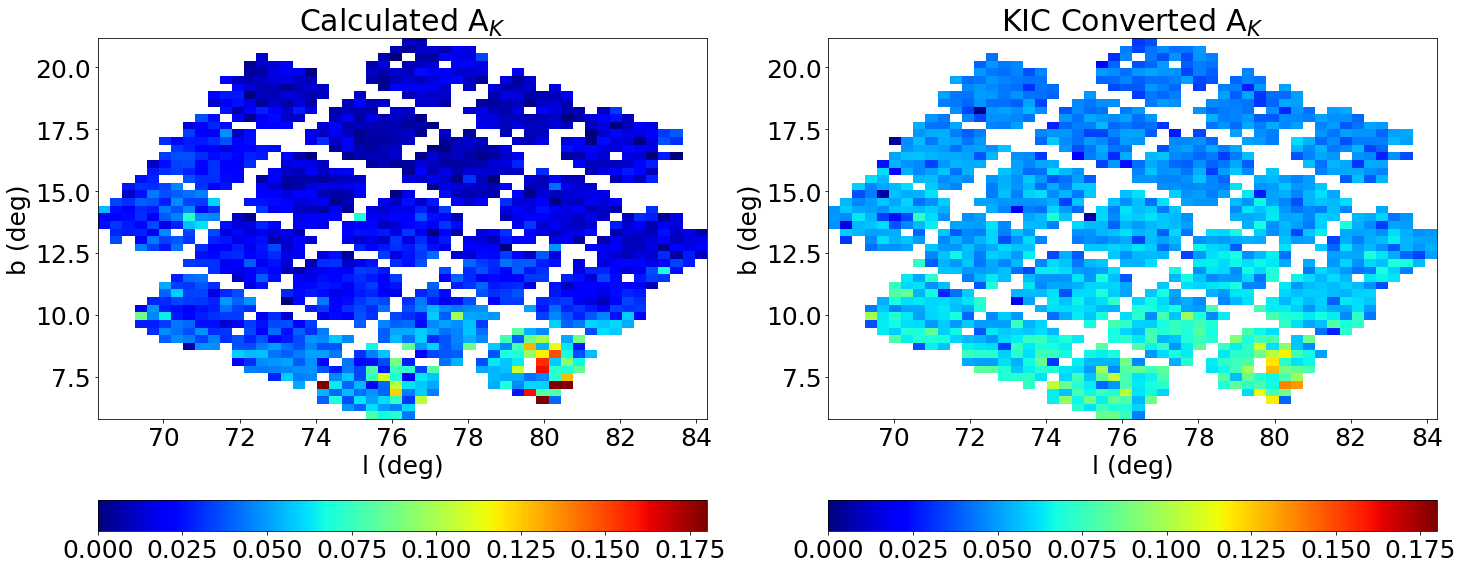

In [388]:
plt.figure(figsize=[24,10])

fincut = np.where((np.isfinite(ak_ext)==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (ak_ext<10.)&(k672dr17['KIC_EBMV']>-10.))

plt.subplot(121)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],ak_ext[fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Calculated A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median(ak_ext[fincut]),mad(ak_ext[fincut])))
print(np.mean(ak_ext[fincut]))
print('-----')

plt.subplot(122)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],k672dr17['KIC_EBMV'][fincut]*ak_ebv,
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print('{:.5f}+/-{:.5f}'.format(np.median(k672dr17['KIC_EBMV'][fincut]*ak_ebv),
                               mad(k672dr17['KIC_EBMV'][fincut]*ak_ebv)))
print(np.mean(k672dr17['KIC_EBMV'][fincut]*ak_ebv))

plt.savefig('../plots/kasc_ext_map.pdf',dpi=300,bbox_inches='tight')

plt.show()

In [332]:
0.05380-0.00934

0.04446

In [333]:
0.02366+0.01155

0.03521

In [389]:
ak_ebv

0.3735961742948368

0.023657848652298807
0.02866736893334211
-----
0.053797845
0.054958336


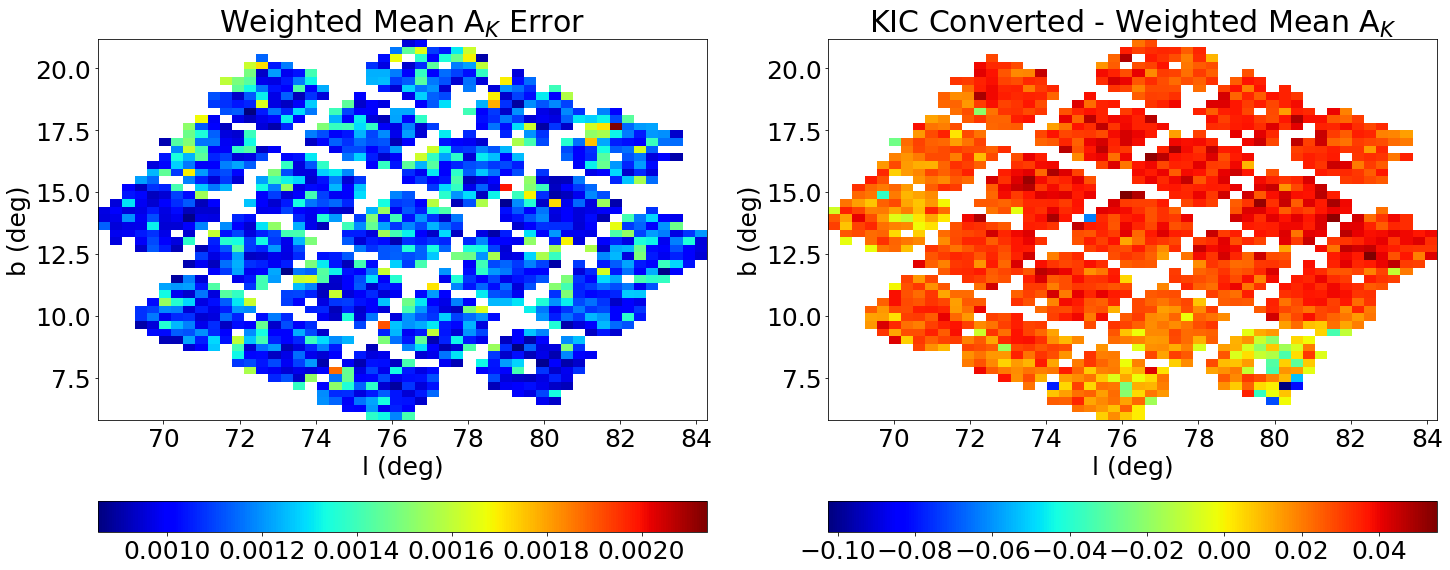

In [318]:
plt.figure(figsize=[24,10])

fincut = np.where((np.isfinite(ak_ext)==True)&(np.isfinite(k672dr17['KIC_EBMV'])==True)&
                  (ak_ext<10.)&(k672dr17['KIC_EBMV']>-10.))

plt.subplot(121)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],ak_ext_err[fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Weighted Mean A$_K$ Error')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(122)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],
                          (k672dr17['KIC_EBMV']*ak_ebv-ak_ext)[fincut],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted - Weighted Mean A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.show()

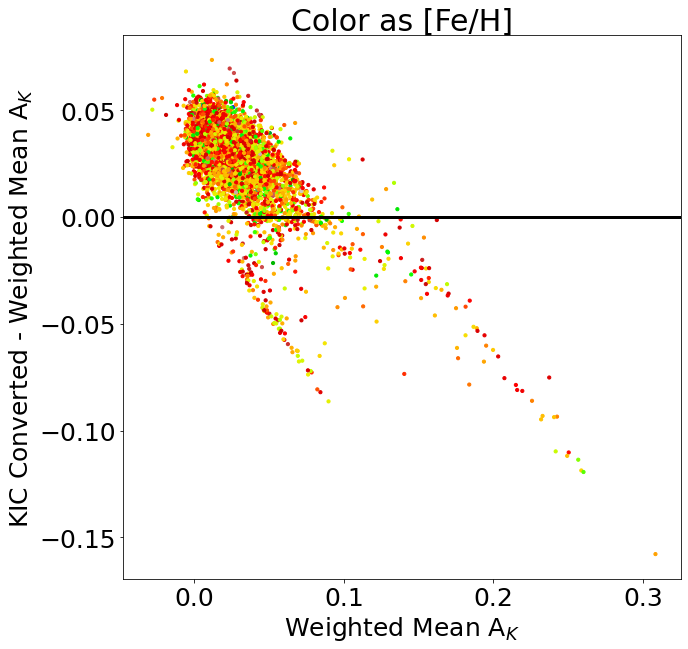

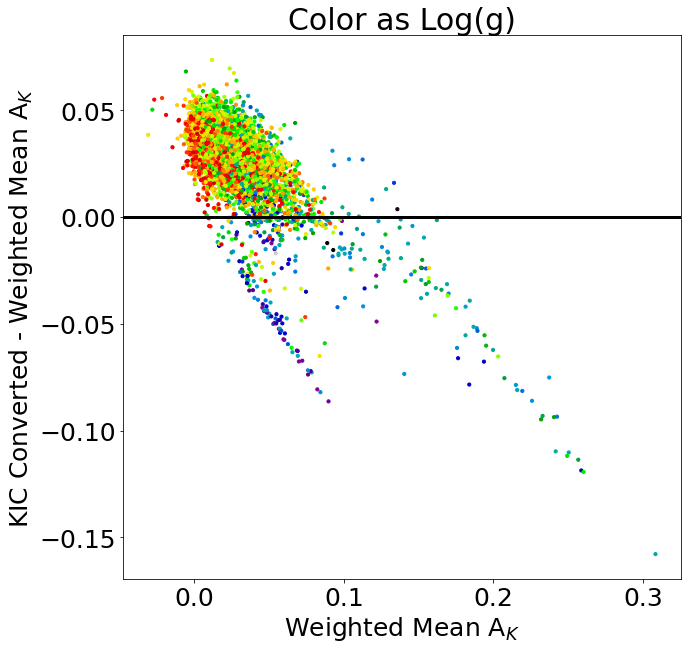

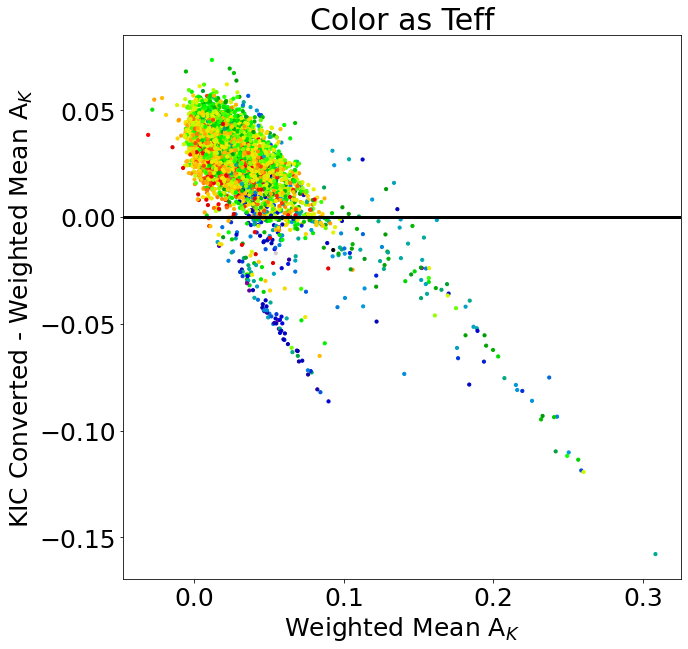

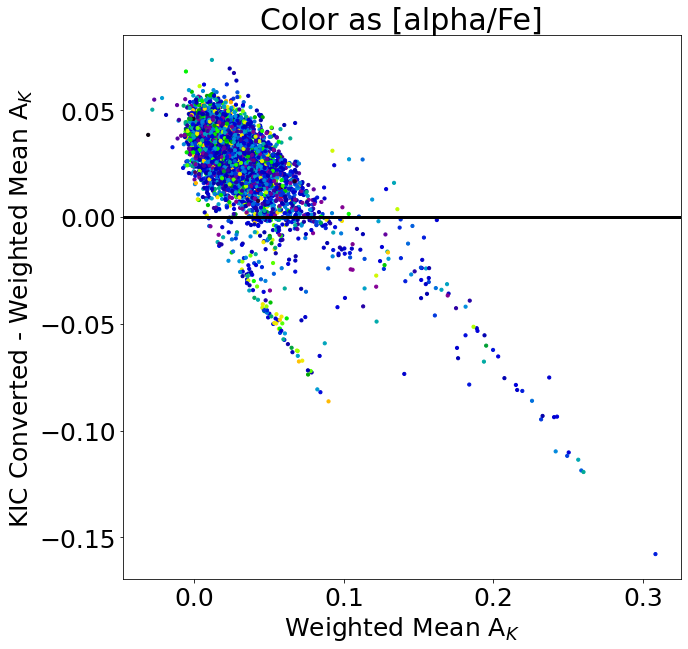

In [321]:
resid_colors = np.array([kdr17['FE_H'],kdr17['LOGG'],kdr17['TEFF'],apoafe])
resid_labels = np.array(['[Fe/H]','Log(g)','Teff','[alpha/Fe]'])

for i in range(len(resid_colors)):
    plt.figure(figsize=[10,10])
    plt.scatter(ak_ext[fincut],(k672dr17['KIC_EBMV']*ak_ebv-ak_ext)[fincut],
                c=resid_colors[i][fincut],cmap='nipy_spectral',s=10)
    plt.axhline(0.0,c='k',lw=3.0)
    plt.title(r'Color as {}'.format(resid_labels[i]))
    plt.xlabel(r'Weighted Mean A$_K$')
    plt.ylabel(r'KIC Converted - Weighted Mean A$_K$')
    plt.show()

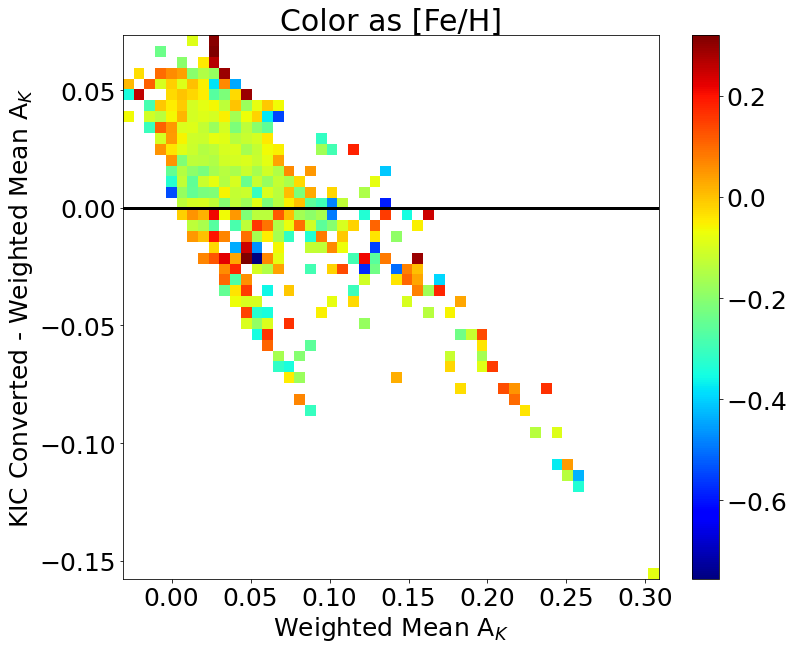

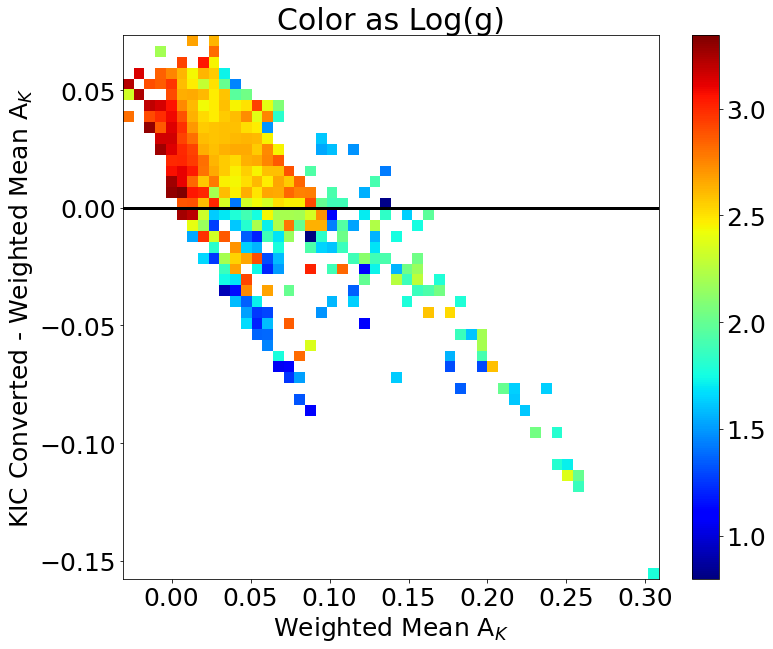

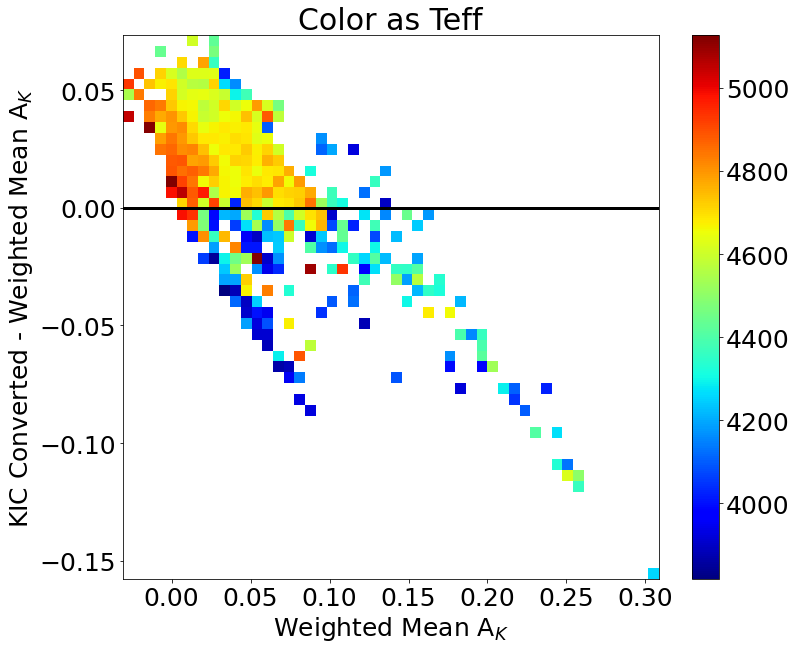

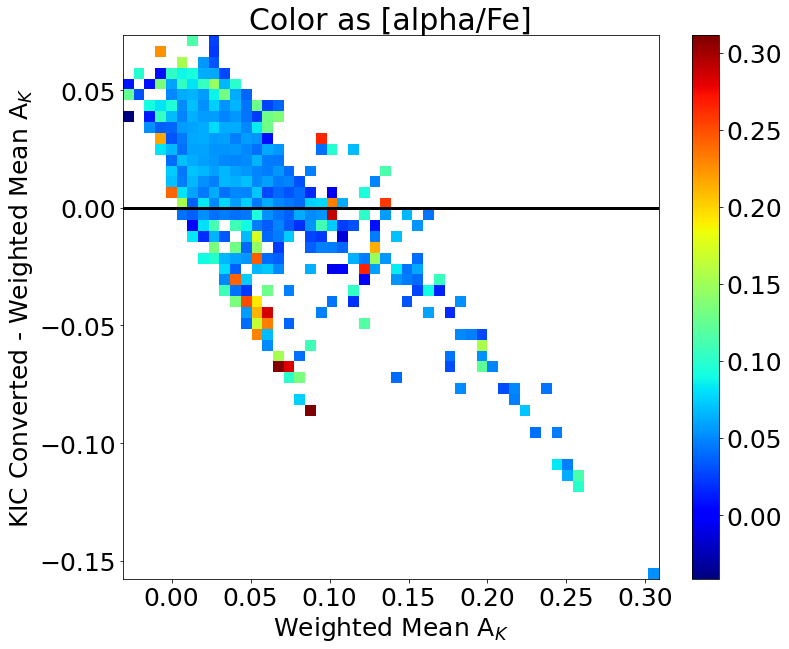

In [325]:
resid_colors = np.array([kdr17['FE_H'],kdr17['LOGG'],kdr17['TEFF'],apoafe])
resid_labels = np.array(['[Fe/H]','Log(g)','Teff','[alpha/Fe]'])

for i in range(len(resid_colors)):
    
    ret = binned_statistic_2d(ak_ext[fincut],(k672dr17['KIC_EBMV']*ak_ebv-ak_ext)[fincut],
                              resid_colors[i][fincut],'median',bins=50)
    
    plt.figure(figsize=[12,10])
#     plt.scatter(ak_ext[fincut],(k672dr17['KIC_EBMV']*ak_ebv-ak_ext)[fincut],
#                 c=resid_colors[i][fincut],cmap='nipy_spectral',s=10)
    plt.imshow(ret.statistic.T, origin='lower',
               extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
               aspect='auto',interpolation='nearest',cmap='jet')
    plt.colorbar()
    plt.axhline(0.0,c='k',lw=3.0)
    plt.title(r'Color as {}'.format(resid_labels[i]))
    plt.xlabel(r'Weighted Mean A$_K$')
    plt.ylabel(r'KIC Converted - Weighted Mean A$_K$')
    plt.show()

In [81]:
ebpk_ak

NameError: name 'ebpk_ak' is not defined

<ipython-input-161-9f6ea732f006>:16: RuntimeWarning: invalid value encountered in double_scalars
  geo_mean[i] = (reds[i,0]*reds[i,1]*reds[i,2]*reds[i,3])**(0.25)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(0.0, 2.5)

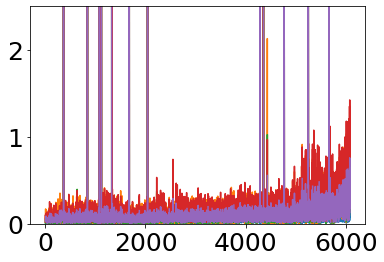

In [161]:
bpkw = leff['BP']-leff['K']
rpkw = leff['RP']-leff['K']
jkw = leff['J']-leff['K']
hkw = leff['H']-leff['K']

width_sum = ((reds[:,0]*bpkw*ak_ebpk+reds[:,1]*rpkw*ak_erpk+reds[:,2]*hkw*ak_ejk+reds[:,3]*hkw*ak_ehk)/
             (bpkw+rpkw+jkw+hkw))
avg_sum = (reds[:,0]*ak_ebpk+reds[:,1]*ak_erpk+reds[:,2]*ak_ejk+reds[:,3]*ak_ehk)

med_ak = 999999.0*np.ones(len(reds))
quad_mean = 999999.0*np.ones(len(reds))
geo_mean = 999999.0*np.ones(len(reds))
for i in range(len(reds)):
    med_ak[i] = np.nanmedian([reds[i,0],reds[i,1],reds[i,2],reds[i,3]])
    quad_mean[i] = np.sqrt((reds[i,0]**2+reds[i,1]**2+reds[i,2]**2+reds[i,3]**2)/4.)
    geo_mean[i] = (reds[i,0]*reds[i,1]*reds[i,2]*reds[i,3])**(0.25)

plt.plot(width_sum)
plt.plot(avg_sum)
plt.plot(med_ak)
plt.plot(quad_mean)
plt.plot(geo_mean)
plt.ylim(0,2.5)

In [93]:
np.where(width_sum<0.0)

(array([   9,   15,   16,   22,   34,   37,   40,   46,   53,   86,  112,
         123,  145,  155,  181,  226,  256,  261,  264,  266,  425,  472,
         482,  501,  508,  542,  593,  596,  657,  783,  807,  861,  867,
         868,  893,  980, 1018, 1029, 1104, 1123, 1127, 1167, 1200, 1209,
        1240, 1241, 1270, 1271, 1293, 1317, 1517, 1563, 1565, 1622, 1628,
        1633, 1641, 1686, 1743, 1774, 1802, 1857, 1875, 1896, 1905, 1924,
        1934, 1991, 2008, 2020, 2084, 2090, 2104, 2142, 2145, 2178, 2379,
        2390, 2440, 2449, 2553, 2616, 2632, 2713, 2764, 2806, 3132, 3138,
        3148, 3181, 3278, 3363, 3436, 3450, 3563, 3569, 3657, 3816, 3868,
        4006, 4127, 4142, 4220, 4356, 4391, 4439, 4446, 4470, 4472, 4475,
        4635, 4646, 4647, 4653, 4808, 4849, 4936, 4990, 5489, 5702, 5757]),)

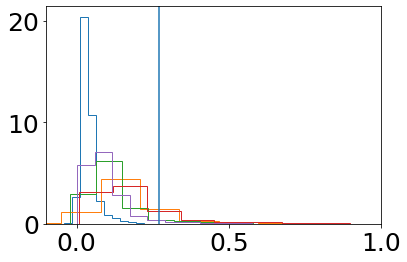

In [162]:
less100 = np.where((width_sum<1.)&(avg_sum<1.)&(med_ak<100.)&(quad_mean<100.)&(geo_mean<100.))
plt.hist(width_sum[less100],histtype='step',density=True)
plt.hist(avg_sum[less100],histtype='step',density=True)
plt.hist(med_ak[less100],histtype='step',density=True)
plt.hist(quad_mean[less100],histtype='step',density=True)
plt.hist(geo_mean[less100],histtype='step',density=True)
plt.xlim(-0.1,1.0)
plt.axvline(0.27)
# np.nanmedian(width_sum[less100])

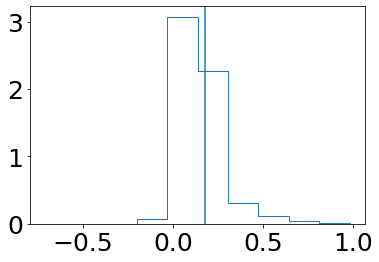

In [102]:
plt.hist(avg_sum[less100],histtype='step',density=True)
plt.axvline(0.180)

0.15213830363765926
0.17461524658726868
-----
0.09375743445972534
0.11545444521237422
-----
0.03184329468076154
0.03780758728515508
-----
0.051929865
0.05669731


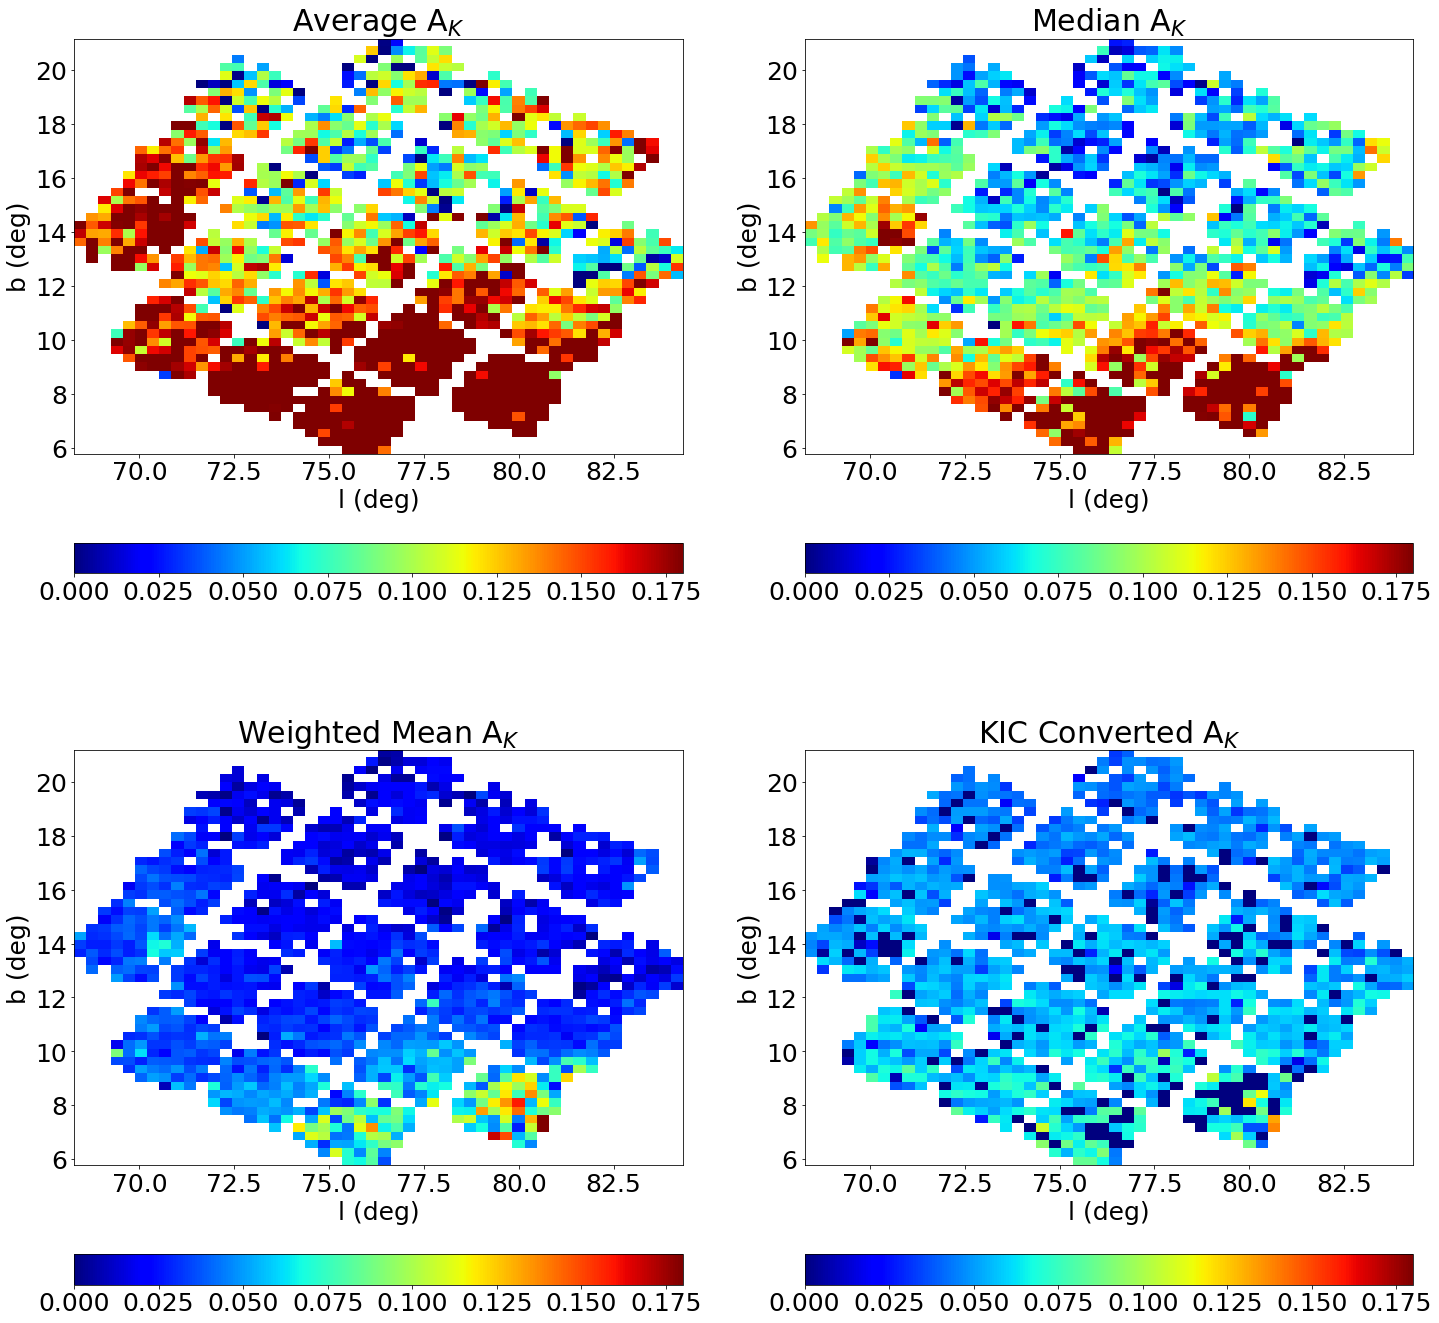

In [215]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[24,24])

plt.subplot(221)
ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],avg_sum[less100],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Average A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print(np.median(avg_sum[less100]))
print(np.mean(avg_sum[less100]))
print('-----')

######
plt.subplot(222)
ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],med_ak[less100],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Median A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print(np.median(med_ak[less100]))
print(np.mean(med_ak[less100]))
print('-----')

######
plt.subplot(223)
ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],width_sum[less100],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Weighted Mean A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print(np.median(width_sum[less100]))
print(np.mean(width_sum[less100]))
print('-----')

######
plt.subplot(224)
ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],
                          k672dr17['KIC_EBMV'][less100]*ak_ebv,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

print(np.median(k672dr17['KIC_EBMV'][less100]*ak_ebv))
print(np.mean(k672dr17['KIC_EBMV'][less100][np.where(k672dr17['KIC_EBMV'][less100]>-10.)]*ak_ebv))

plt.show()

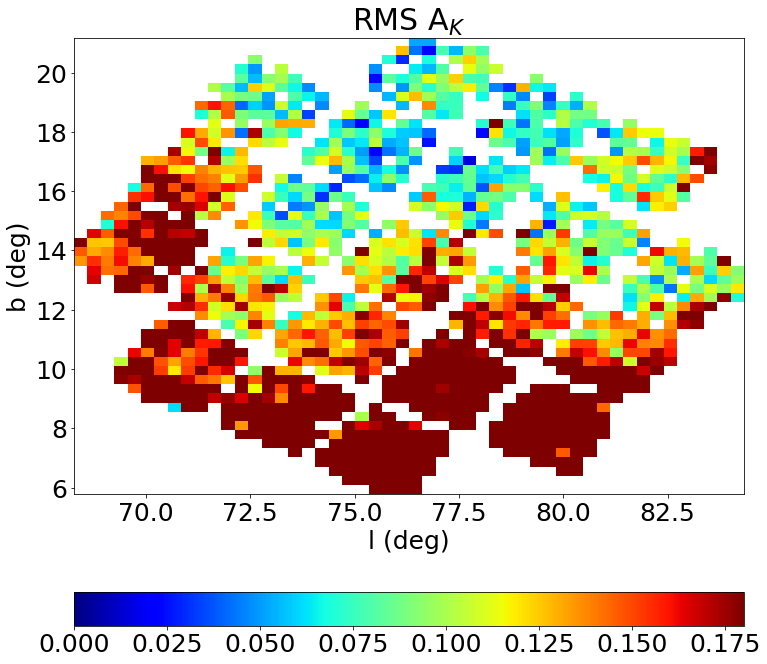

0.1498068657294381
0.18551931588041443


In [165]:
plt.figure(figsize=[12,12])

ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],quad_mean[less100],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'RMS A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')
plt.show()

print(np.median(quad_mean[less100]))
print(np.mean(quad_mean[less100]))

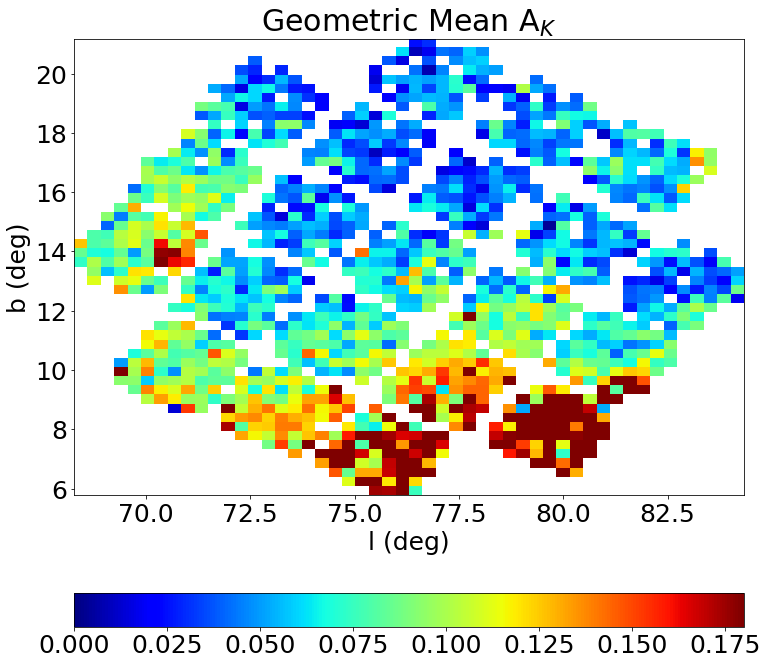

0.1498068657294381
0.18551931588041443


In [166]:
plt.figure(figsize=[12,12])

ret = binned_statistic_2d(kdr17['GLON'][less100],kdr17['GLAT'][less100],geo_mean[less100],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=0.180)

plt.colorbar(orientation='horizontal')

plt.title(r'Geometric Mean A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')
plt.show()

print(np.median(quad_mean[less100]))
print(np.mean(quad_mean[less100]))

(-0.01, 0.2)

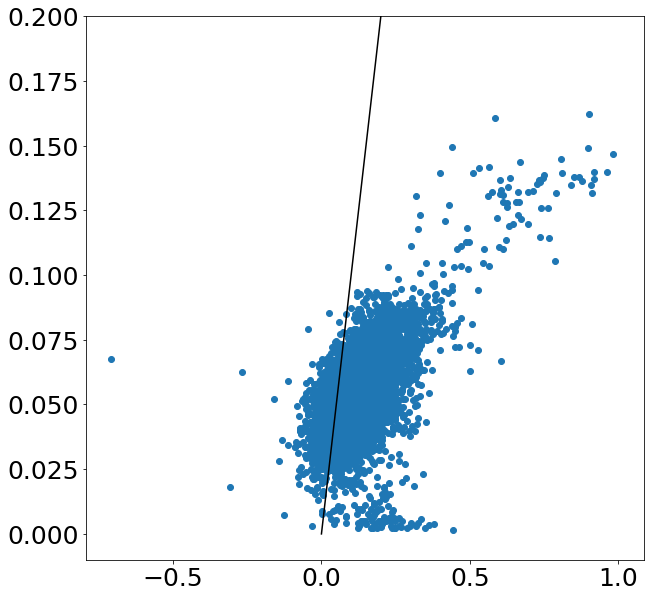

In [126]:
plt.figure(figsize=[10,10])
plt.scatter(avg_sum[less100],k672dr17['KIC_EBMV'][less100]*ak_ebv)
plt.plot([0.,1.],[0.,1.],c='k')
plt.ylim(-0.01,0.2)

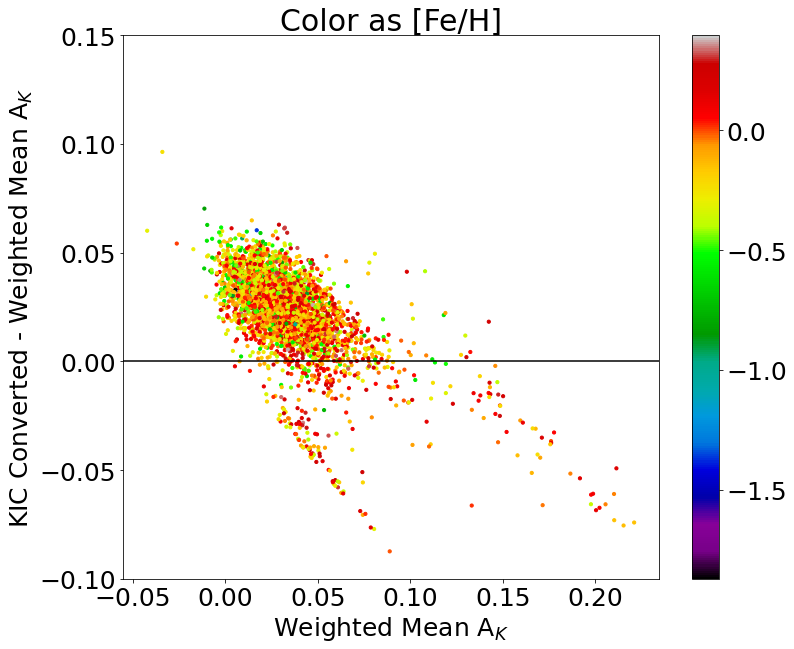

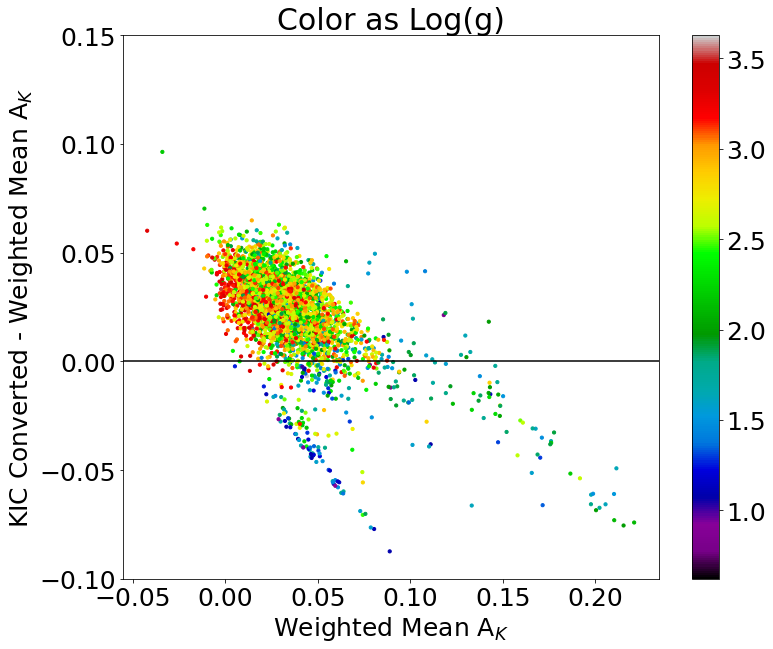

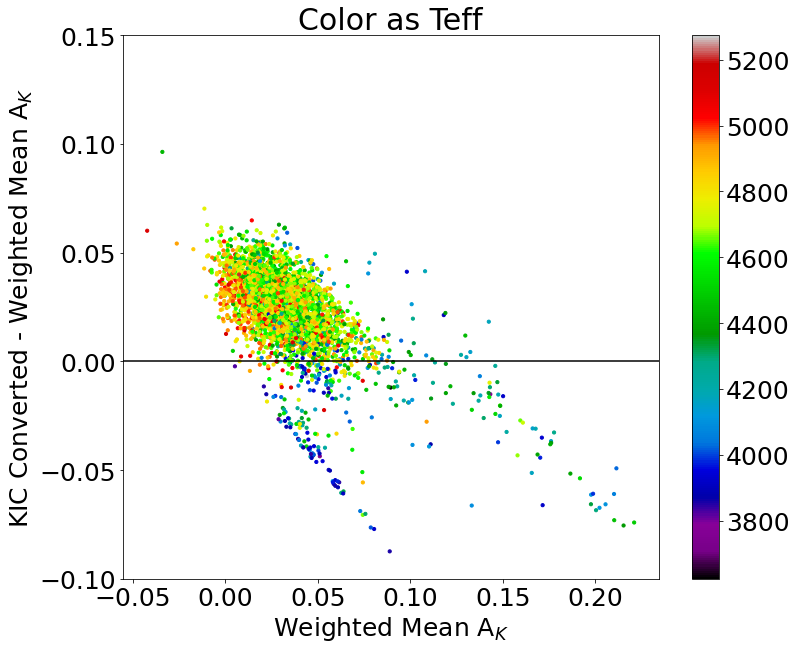

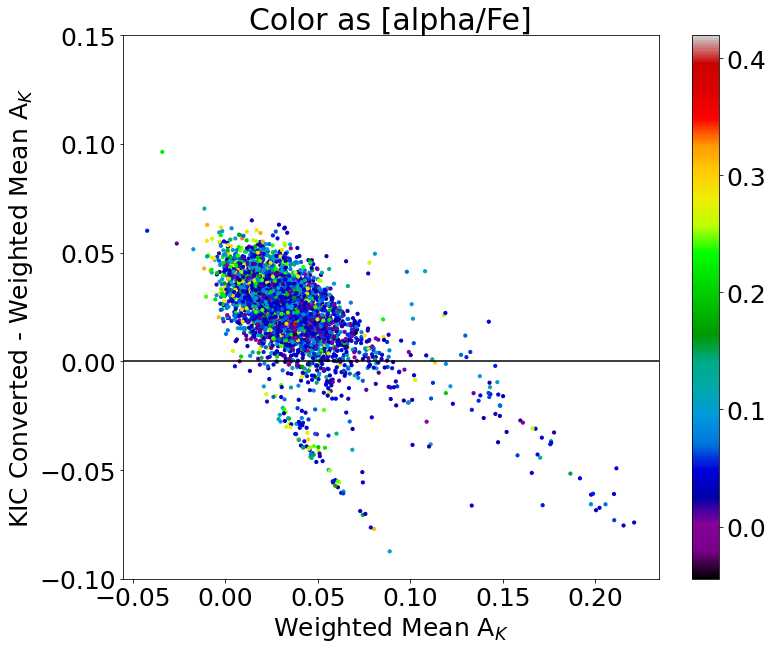

In [186]:
resid_colors = np.array([kdr17['FE_H'],kdr17['LOGG'],kdr17['TEFF'],apoafe])
resid_labels = np.array(['[Fe/H]','Log(g)','Teff','[alpha/Fe]'])

for i in range(len(resid_colors)):
    
    plt.figure(figsize=[12,10])
    plt.scatter(width_sum[less100],k672dr17['KIC_EBMV'][less100]*ak_ebv-width_sum[less100],
                c=resid_colors[i][less100],cmap='nipy_spectral',s=10)
    
    plt.colorbar()
    
    plt.axhline(0.0,c='k')
    
    plt.ylim(-0.1,0.15)

    plt.title(r'Color as {}'.format(resid_labels[i]))
    plt.xlabel(r'Weighted Mean A$_K$')
    plt.ylabel(r'KIC Converted - Weighted Mean A$_K$')
    plt.show()

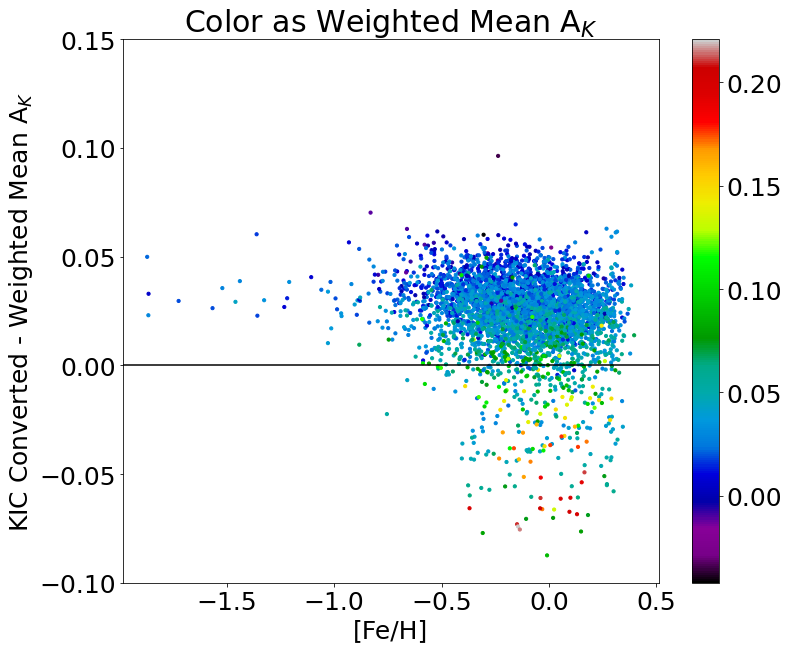

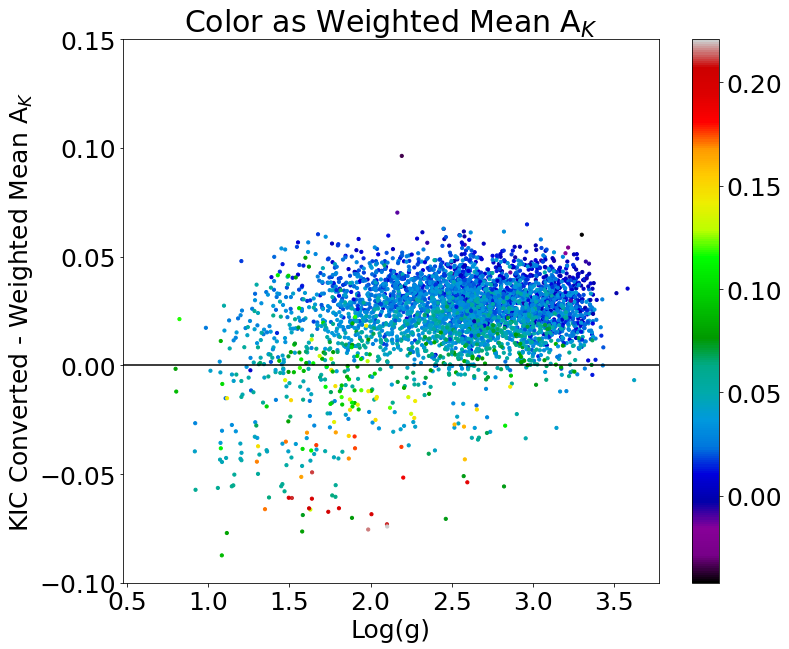

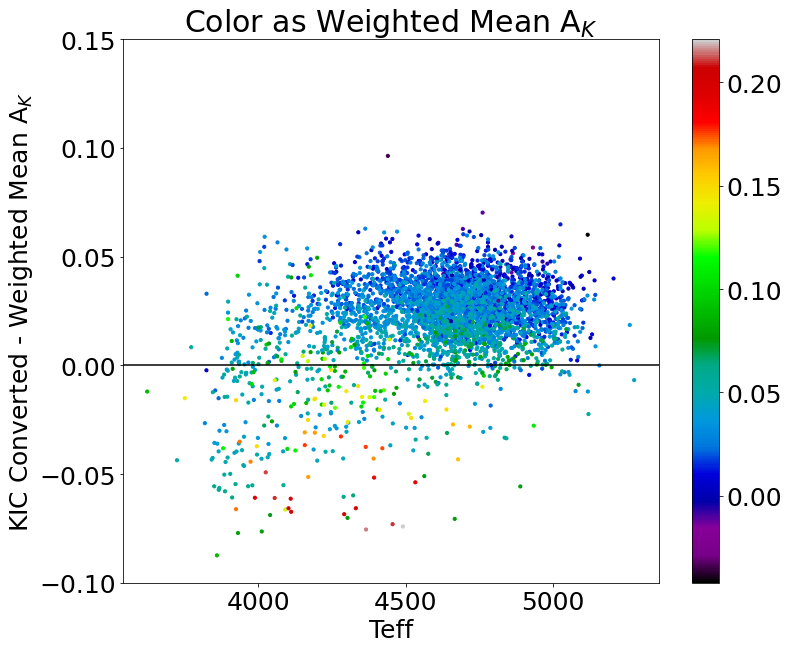

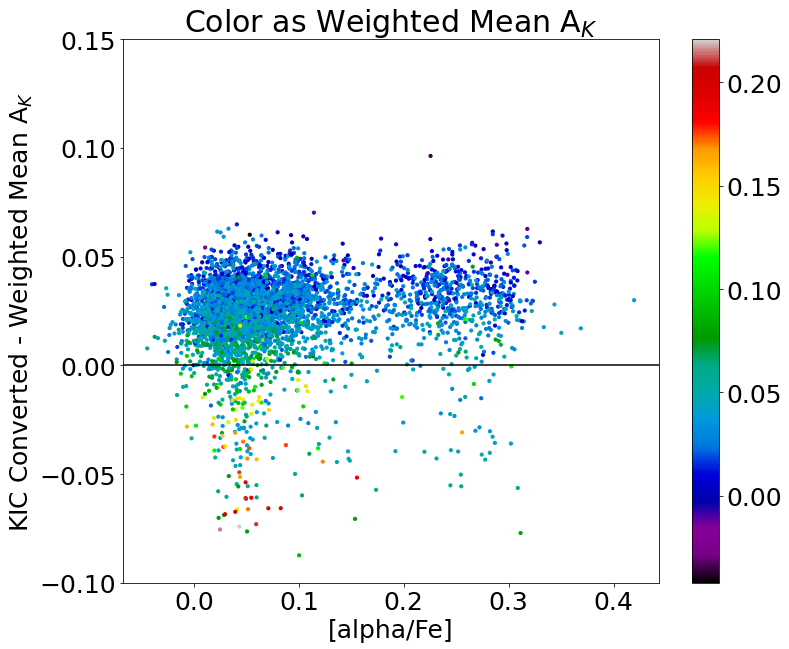

In [190]:
for i in range(len(resid_colors)):
    
    plt.figure(figsize=[12,10])
    plt.scatter(resid_colors[i][less100],k672dr17['KIC_EBMV'][less100]*ak_ebv-width_sum[less100],
                c=width_sum[less100],cmap='nipy_spectral',s=10)
    plt.colorbar()
    
    plt.axhline(0.0,c='k')
    
    plt.ylim(-0.1,0.15)
    
    plt.title(r'Color as Weighted Mean A$_K$')
    plt.xlabel(r'{}'.format(resid_labels[i]))
    plt.ylabel(r'KIC Converted - Weighted Mean A$_K$')
    plt.show()

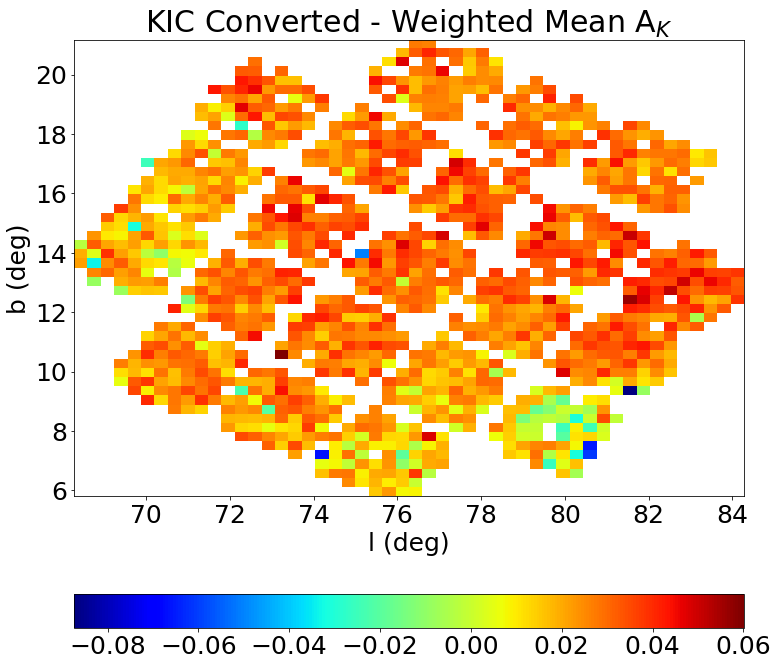

0.1498068657294381
0.18551931588041443


In [213]:
locut = np.where(k672dr17['KIC_EBMV'][less100]>-100.)

plt.figure(figsize=[12,12])

ret = binned_statistic_2d(kdr17['GLON'][less100][locut],
                          kdr17['GLAT'][less100][locut],(k672dr17['KIC_EBMV']*ak_ebv-width_sum)[less100][locut],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'KIC Converted - Weighted Mean A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')
plt.show()

print(np.median(quad_mean[less100]))
print(np.mean(quad_mean[less100]))